In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [73]:
env = BlackjackEnv()

In [10]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [14]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        policy = np.zeros(len(Q[observation]))
        policy[np.argmax(Q[observation])] = 1.0
        return policy
        
    return policy_fn

In [25]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    
    for n in range(num_episodes):
        episode = []
        s = env.reset()
        for t in range(100):
            behav_prob =  behavior_policy(s)
            a = np.random.choice(range(len(behav_prob)), p=behav_prob)
            sp, r, done, _ = env.step(a)
            episode.append((s,a,r))
            if done:
                break
            s = sp
            
        G = 0
        W = 1
        for t in range(len(episode)-2, -2, -1):
            Rtp1 = episode[t+1][2]
            St = episode[t][0]
            At = episode[t][1]
            
            G = discount_factor*G + Rtp1
            C[St][At] += W
            Q[St][At] += W/C[St][At]*(G-Q[St][At])
            if At != np.argmax(Q[St][At]):
                break
            W = W/behavior_policy(St)[At]
            
        
    return Q, target_policy

In [7]:
[i for i in range(10,0,-1)]

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [ ]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

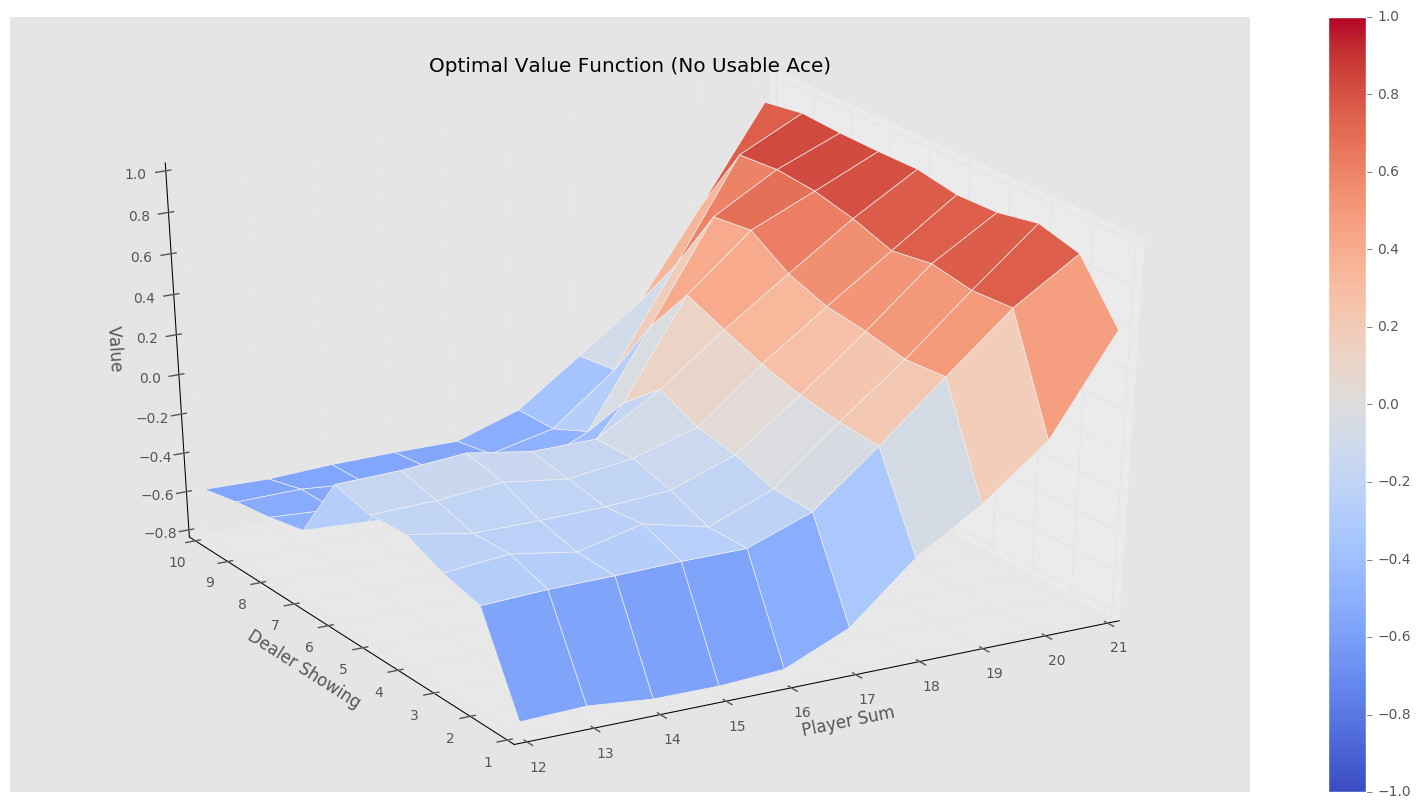

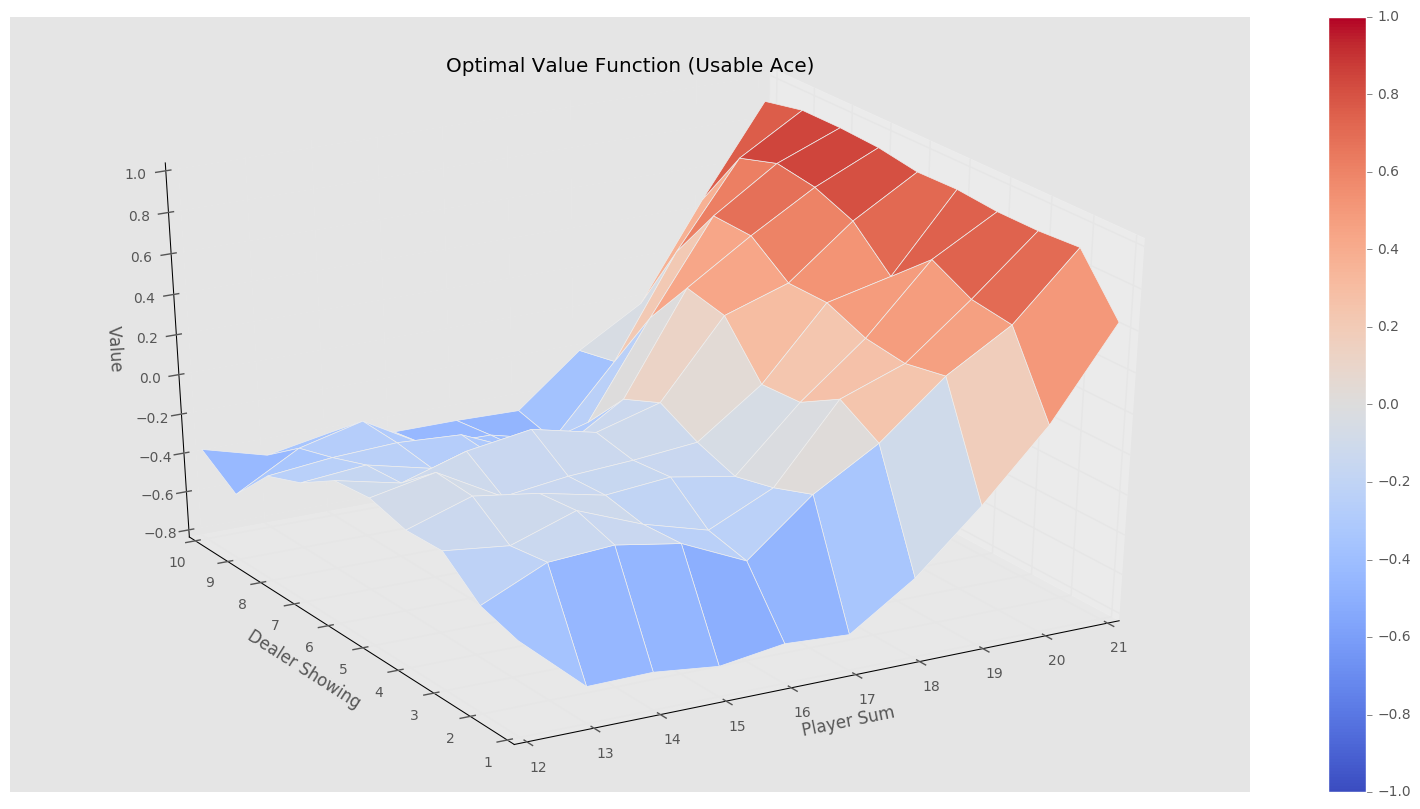

In [27]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [19]:
env = BlackjackEnv()
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    #return 0 if score >= 20 else 1
    return np.argmax(policy((score,dealer_score,usable_ace)))

total_reward = 0.

N = 2000
for i_episode in range(N):
    observation = env.reset()
    for t in range(100):
        #print_observation(observation)
        action = strategy(observation)
        #print("Taking action: {}".format( ["Stick", "Hit"][action]))
        observation, reward, done, _ = env.step(action)
        if done:
            #print_observation(observation)
            #print("Game end. Reward: {}\n".format(float(reward)))
            total_reward += reward
            break
            
print("Average reward: {}".format(total_reward/N))

Average reward: -0.082


In [35]:
policy((12,1,True))

array([ 0.,  1.])